## Classify and count sea lions from image

In [1]:
INPUT_DIR = '../../input/kaggle-sea-lion/'
OUTPUT_DIR = '../../output/kaggle-sea-lion/10/'

IMAGE_DIMS = (84,84,3)
LOAD_WEIGHTS_FILE = INPUT_DIR + '05/weights-0.72-simple.h5'
LOAD_MODEL_FILE = None

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob
import cv2

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn
import modules.lions as lions
import modules.objectdetect as objectdetect

Using TensorFlow backend.


### Prepare output dir

In [3]:
utils.mkdirs(OUTPUT_DIR, recreate=True)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
logger.info('Dir ' + OUTPUT_DIR + ' created')

2017-05-23 07:55:13,417 INFO Dir ../../output/kaggle-sea-lion/10/ created


In [4]:
#from MismatchedTrainImages.txt
MISMATCHED = [3, 7, 9, 21, 30, 34, 71, 81, 89, 97, 151, 184, 215, 234, 242, 268, 290, 311, 331, 344, 380, 384, 406, 421, 469, 475, 490, 499, 507, 530, 531, 605, 607, 614, 621, 638, 644, 687, 712, 721, 767, 779, 781, 794, 800, 811, 839, 840, 869, 882, 901, 903, 905, 909, 913, 927, 946]


### Load trained CNN model

In [5]:
logger.info('Load CNN model')
#model = lions.convnet_alexnet2_lion_keras(IMAGE_DIMS)

model = None
if(LOAD_MODEL_FILE!=None and os.path.isfile(LOAD_MODEL_FILE)):
    with open(LOAD_MODEL_FILE, 'r') as model_file:
        my = model_file.read()
        model = models.model_from_yaml(my)
        logger.info('loaded model from file ' + LOAD_MODEL_FILE)
else:
    model = lions.convnet_simple_lion_keras(IMAGE_DIMS)
    logger.info('loaded model from function convnet_simple_lion_keras')

if(LOAD_WEIGHTS_FILE!=None and os.path.isfile(LOAD_WEIGHTS_FILE)):
    model.load_weights(LOAD_WEIGHTS_FILE)
    logger.info('Loaded model weights from ' + LOAD_WEIGHTS_FILE)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])    
logger.info('Model prepared')

2017-05-23 07:55:13,481 INFO Load CNN model
2017-05-23 07:55:13,631 INFO loaded model from function convnet_simple_lion_keras
2017-05-23 07:55:13,986 INFO Loaded model weights from ../../input/kaggle-sea-lion/05/weights-0.72-simple.h5
2017-05-23 07:55:14,013 INFO Model prepared


## Classify lion class using CNN

### Perform sliding window search

[[ 0.01126887  0.00678519  0.01099778  0.03986485  0.90895891  0.02212437]]


2017-05-23 07:59:42,811 INFO > [started] sliding_window...


816/828 [=========================>] 98% 9s remaining=0s sliding window

2017-05-23 07:59:52,289 INFO > [done]    sliding_window (9478.786 ms)
2017-05-23 07:59:52,290 INFO > [started] non_max_suppression. boxes=11755...
2017-05-23 07:59:52,339 INFO > [done]    non_max_suppression. boxes=11755 (48.337 ms)


regions found:
3


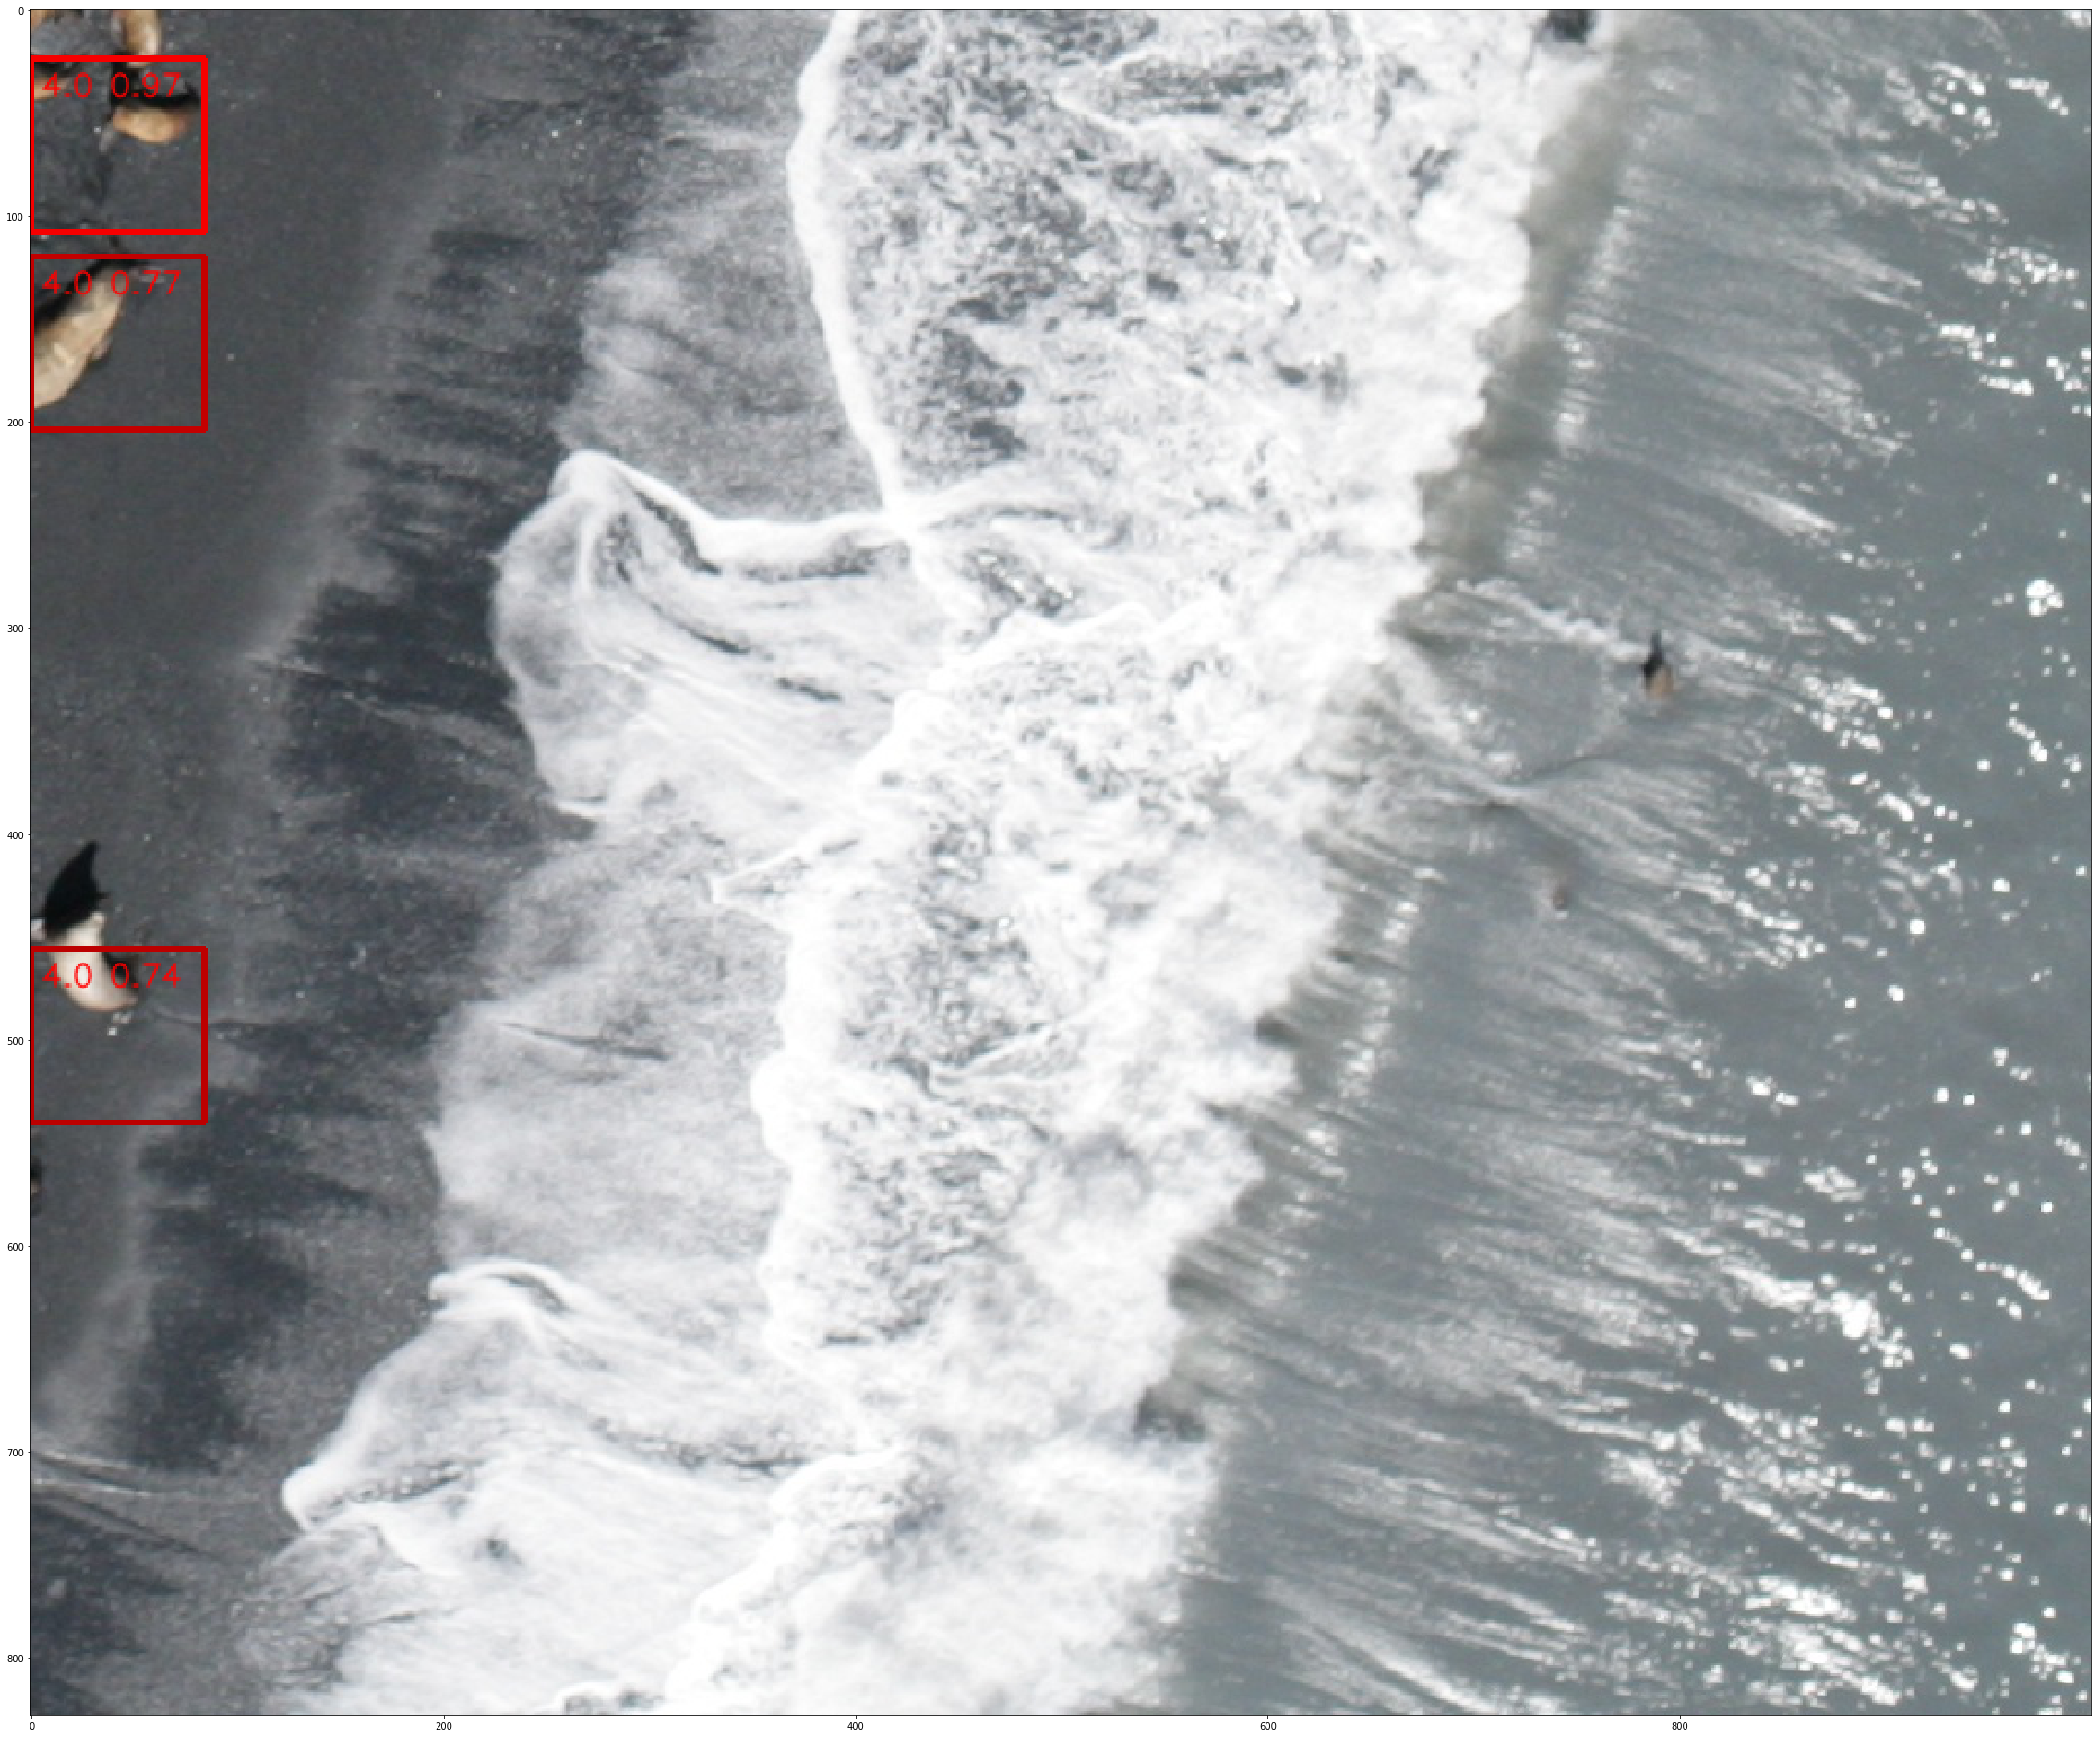

2017-05-23 07:59:53,828 INFO showing 0 images
2017-05-23 07:59:53,836 INFO > [started] generating image patches. rows=1; cols=10...


2017-05-23 07:59:53,838 INFO > [done]    generating image patches. rows=1; cols=10 (2.469 ms)


In [10]:
img_path = INPUT_DIR + 'Train/41.jpg'
img = cv2.imread(img_path)
#img = img[1800:4000,2000:3300]
img = img[2500:3500,3000:4000]
#img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY).astype('u1')

y_pred = model.predict(np.array([img[0:84,0:84]]))
print(y_pred)

#lion simple cnn forward time: ~10ms
model = lions.convnet_simple_lion_keras(IMAGE_DIMS)
model.load_weights(LOAD_WEIGHTS_FILE)

""" Returns (score, label) """
def eval_region(region_img):
    y_pred = model.predict(np.array([region_img]))
    ylp = utils.onehot_to_label(np.array(y_pred))
    return y_pred[0][ylp[0]], ylp[0]

img2 = img.copy()

region_generator = objectdetect.sliding_window_generator(img2, step=(24,24), window=IMAGE_DIMS, pyramid_max_layers=1)
detections, imgs = objectdetect.evaluate_regions(region_generator, eval_region, filter_score_min=0.6, filter_labels=(0,1,2,3,4), apply_non_max_suppression=True, supression_overlap_threshold=0.1, threads=None)

print('regions found:')
print(len(detections))

def detection_to_colortext(detection):
    score = detection[4]
    text = str(detection[5]) + ' ' + '{0:.2f}'.format(score)
    c = int(score*255)
    return (0,0,c), text

objectdetect.draw_detections(detections, img2, detection_to_colortext)
utils.show_image(img2, size=40, is_bgr=True)

patches = objectdetect.extract_patches(detections, img2)
utils.show_images(patches[100:160], size=2, cols=10)

## Verify classification/count performance